In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

from skimage.io import imshow, imread, imsave
from skimage import img_as_float, img_as_ubyte
from skimage.filters import threshold_otsu

from sklearn.cluster import KMeans
np.random.seed(100)

# Задание 1

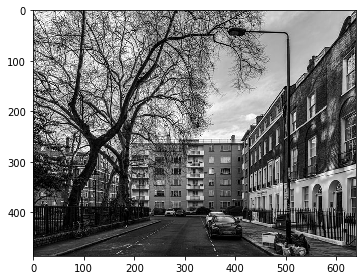

In [2]:
# Импортирую изображение
img = imread('grayscale.jpg', as_gray=True)
# Отобразить изображение
imshow(img)

In [3]:
img[:20, :20]

array([[0.89803922, 0.94901961, 0.96078431, 0.91372549, 0.87843137,
        0.91764706, 0.73333333, 0.84705882, 0.9372549 , 0.8627451 ,
        0.96862745, 0.91372549, 0.93333333, 0.94117647, 0.88235294,
        0.89803922, 0.59215686, 0.89019608, 0.94117647, 0.92941176],
       [0.95294118, 0.99607843, 0.97647059, 0.88235294, 0.83529412,
        0.97254902, 0.86666667, 0.90980392, 0.85882353, 0.63137255,
        0.8745098 , 0.89411765, 0.76470588, 0.9372549 , 0.84705882,
        0.95294118, 0.80784314, 0.76862745, 0.90588235, 0.98431373],
       [0.97647059, 0.94901961, 0.96078431, 0.72941176, 0.58039216,
        0.96862745, 1.        , 1.        , 0.81568627, 0.43529412,
        0.76862745, 0.89411765, 0.54117647, 0.85882353, 0.82352941,
        0.71764706, 0.94509804, 0.67843137, 0.79215686, 0.87058824],
       [0.9372549 , 0.91372549, 0.97647059, 0.83137255, 0.68627451,
        0.95686275, 0.97254902, 1.        , 0.75686275, 0.87058824,
        1.        , 0.97254902, 0.78431373, 0

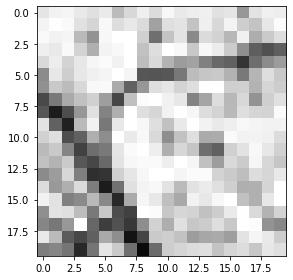

In [4]:
imshow(img[:20, :20])

### Применим Оцу

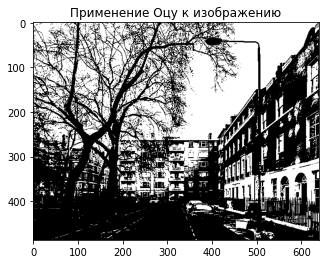

In [5]:
# Нахожу пороговое значение
threshold = threshold_otsu(img)
# Все что больше порогового - белое, а меньше - черное
img_otsu = (img > threshold).astype(int)
# Вывод изображения
plt.imshow(img_otsu, cmap='gray')
plt.title('Применение Оцу к изображению');

### Применим kmeans

Kmeans на игрушечных

In [40]:
from sklearn.datasets import make_blobs

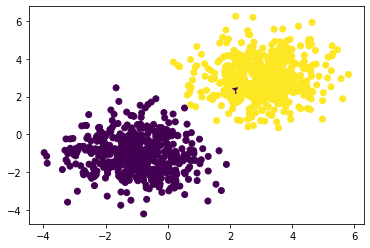

In [12]:
# Cгенерирую данные
X_toy, y_toy= make_blobs(n_samples=1000, centers=[[-1, -1],[3, 3]])
# Отображу данные
plt.scatter(X_toy[:, 0], X_toy[:, 1], c=y_toy)

Применим кластеризацию kmeans

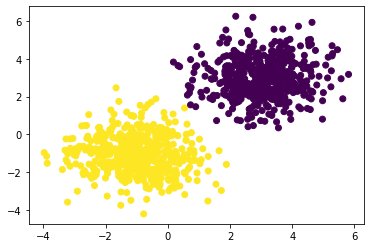

In [13]:
kmeans = KMeans(n_clusters=2)
cluster = kmeans.fit_predict(X_toy)
plt.scatter(X_toy[:, 0], X_toy[:, 1], c=cluster)

kmeans  для бинаризации изображения

/home/vsevolod/miniconda3/envs/main/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


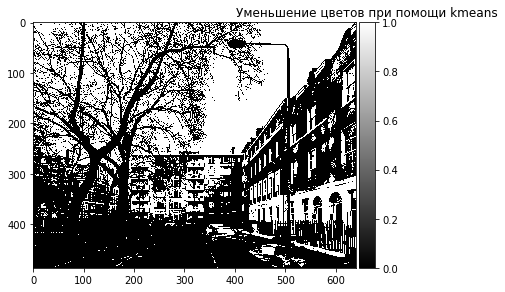

In [14]:
def cluster_to_color(clusters_2d,  colors_2d):
    """
    Ф-ция для получения цвета из кластеров
    """
    clusters_2d_reversed = (clusters_2d == 0).astype(int)
    mae_original = np.sum(np.abs(clusters_2d - colors_2d))
    mae_reversed = np.sum(np.abs(clusters_2d_reversed - colors_2d))
    if mae_original <  mae_reversed:
        return  clusters_2d
    else:
        return  clusters_2d_reversed
# Преобразуем изображение из 2-х мерного в 1 мерное
X = np.ravel(img)[:, np.newaxis]
# Применим кластеризацию
model = KMeans(n_clusters=2)
img_kmens = model.fit_predict(X)
img_kmens = img_kmens.reshape(img.shape)
img_kmens = cluster_to_color(img_kmens, img)
# Показать результат
imshow(img_kmens, cmap='gray')
plt.title('Уменьшение цветов при помощи kmeans');

### Сравниваем результат

In [15]:
percent_equal = np.sum(img_kmens == img_otsu)/ img_kmens.size  * 100
print('Процент совпадения пикселей для методов Оцу и kmeans:', percent_equal)

Процент совпадения пикселей для методов Оцу и kmeans: 99.6345610882957


Вывод: эти методы идентичны

# Задание 2

In [2]:
from sklearn.mixture import GaussianMixture as GM
from sklearn.cluster import MeanShift, estimate_bandwidth
from skimage.color import rgb2lab, rgb2gray

from skimage.feature import canny

from PIL import Image, ImageFilter
from skimage.segmentation import felzenszwalb

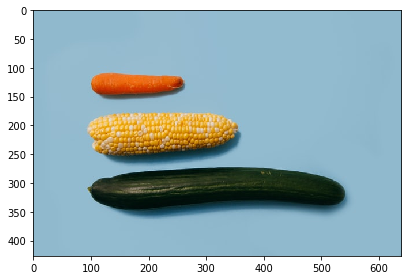

In [3]:
# Импортируем изображение
img = imread('vegetables.jpg')
img_pil = Image.open('vegetables.jpg')
imshow(img)

In [5]:
def plot_image(img, title, **plot_parameters):
    """
    Ф-ция для отображения изображения без осей и с названием
    """
    ax = plt.gca()
    ax.imshow(img, **plot_parameters)
    ax.set_title(title)
    ax.axis('off')

In [6]:
def get_colors_from_clusters(img, clusters):
    """
    Данная ф-ция преобразует кластеризованное изображение в цветное
    """
    # Получим список сегментов
    segments = np.unique(clusters)
    # Сделаем 2d изображение из 3 d
    flat_image = img.reshape((-1, 3))
    # Инициалируем списки для подсчета количествао и суммы значений пикселей
    total = np.zeros((segments.shape[0], 3), dtype=float)
    count = np.zeros(total.shape, dtype=float)
    # Подсчитаем количество и сумму
    for i, label in enumerate(clusters):
        total[label] = total[label] + flat_image[i]
        count[label] += 1
    # Найдем средний цвет для каждого кластера
    avg = total/count
    avg = np.uint8(avg)
    # Получим итоговое изображение
    res = avg[clusters]
    res = res.reshape((img.shape))
    return res

In [7]:
def img_flat_simple(img):
    """
    Сделать изображение 2-х мерным
    """
    return img.reshape(-1, 3)

In [8]:
def perform_segmentation(img, img_transformation_method, model):
    """
    Ф-ция для проделывания сегментации
    """
    X = img_transformation_method(img)
    clusters = model.fit_predict(X)
    return get_colors_from_clusters(img, clusters)

## Смотрим алгоритмы на игрушечных данных

### Mean Shift

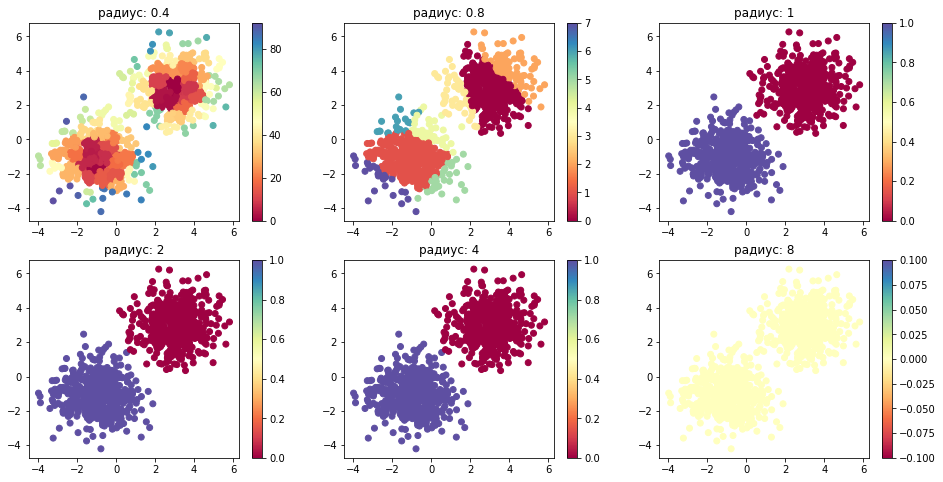

In [27]:
# Список различных радиусов
bandwidths = [0.4, 0.8, 1, 2, 4, 8]
i = 1
fig = plt.figure(figsize=(16, 8))
# Отображаем работу алгоритма при различных радиусах
for band in bandwidths:
    # Инициалируем алгоритм и предсказываем кластеры
    mean_shift = MeanShift(bandwidth=band, bin_seeding=True)
    clusters = mean_shift.fit_predict(X_toy)
    # Отображаем
    plt.subplot(2, 3, i)
    plt.scatter(X_toy[:, 0], X_toy[:, 1], c=clusters, cmap='Spectral')
    plt.title(f'радиус: {band}')
    plt.colorbar()
    i += 1

Gaussian Mixter Models

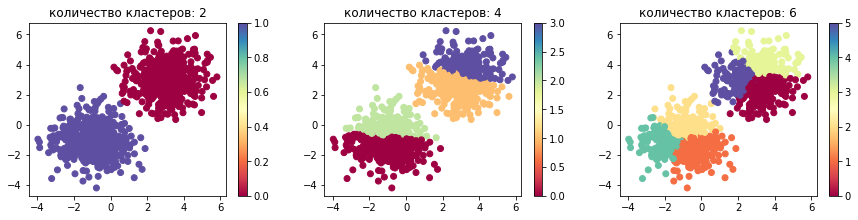

In [26]:
components_list = [2, 4, 6]
i = 1
fig = plt.figure(figsize=(15, 7))
# Отображаем работу алгоритма при различных радиусах
for n_components in components_list:
    # Инициалируем алгоритм и предсказываем кластеры
    gmm = GM(n_components=n_components, covariance_type='tied')
    clusters = gmm.fit_predict(X_toy)
    # Отображаем
    plt.subplot(2, 3, i)
    plt.scatter(X_toy[:, 0], X_toy[:, 1], c=clusters, cmap='Spectral')
    plt.title(f'количество кластеров: {n_components}')
    plt.colorbar()
    i += 1

## Применим алгоритмы без предобработки данных

### GMM

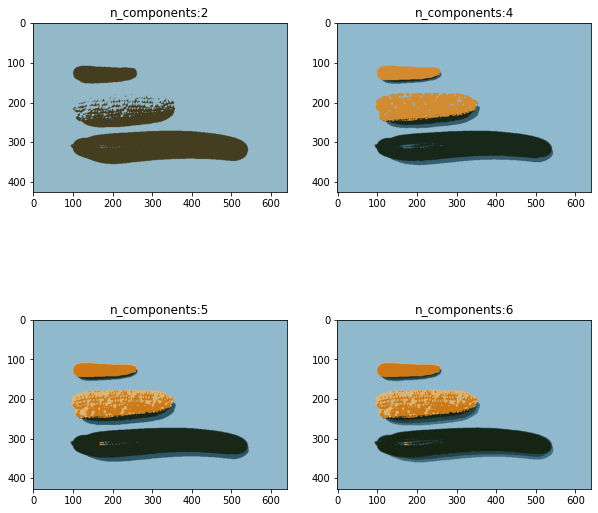

In [101]:
# Иницилируем список различного количества кластеров
n_components_list = [2, 4, 5, 6]
# Задаем размер и количество подграфик
fig, axis = plt.subplots(2, 2, figsize=(10, 10))
for i, n_components in enumerate(n_components_list):
    ax = axis.flat[i]
    # Подготовливаем GMM
    model = GM(n_components=n_components, covariance_type='tied')
    # Получаем цвета при помощи моей ф-ции perform_segmantation
    img_gm = perform_segmentation(img, img_flat_simple, model)
    # Отображаем изображние
    ax.imshow(img_gm)
    ax.set_title(f'Количество кластеров:{n_components}')

Рассмотрим 5 компонентов поближе

/home/vsevolod/miniconda3/envs/main/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


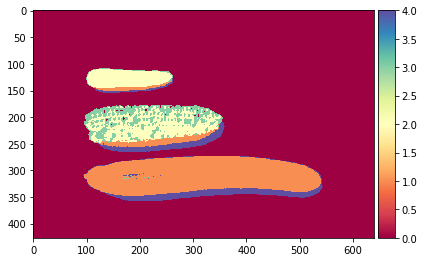

In [124]:
# Подготавливаем модель
model = GM(n_components=5, covariance_type='tied')
X = img_flat_simple(img)
# Получаем кластеры
clusters = model.fit_predict(X)
img_gm = clusters.reshape(img.shape[:2])
# Отображаем кластеры
imshow(img_gm, cmap='Spectral')

Вывод: при 5 компонентах мы получаем на вид довольно приятно изображение, но как видно из предыдущего изображения сегментация не слишком успешна, т.к.  сегменты овощей перекликаются

### Mean shift

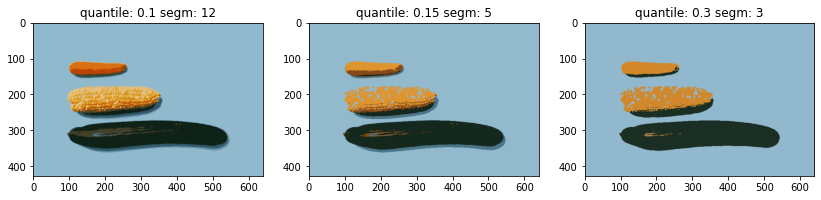

In [122]:
#  Инициализируем список параметров для ф-ции, которая предсказывает радиус
quantiles = [0.1, 0.15, 0.3]
fig, axis = plt.subplots(1, 3, figsize=(14, 4))
for i, quantile in enumerate(quantiles):
    ax = axis[i]
    # Предсказываем радиус
    bandwidth = estimate_bandwidth(X, quantile=quantile, n_samples=3000)
    # Подготавливаем модель
    model = MeanShift(bandwidth=bandwidth, max_iter=500, bin_seeding=True)
    # Проводим сегметнацию
    img_mean_shift = perform_segmentation(img, img_flat_simple, model)
    segments =np.unique(img_mean_shift.reshape(-1, 3),axis=0).shape[0]
    # Ототбражаем
    ax.imshow(img_mean_shift)
    ax.set_title(f'quantile: {quantile} segm: {segments}')

Вывод: как видно из изображений сегментацию трудно назвать успешной, потому что при quantile=0.1 у нас получается слишком много сегментов, а для quantile<= 0.15 нам не удается четко разделить овощи

## Выполним предобработку данных

### Сгладим изображение

Average сглаживание

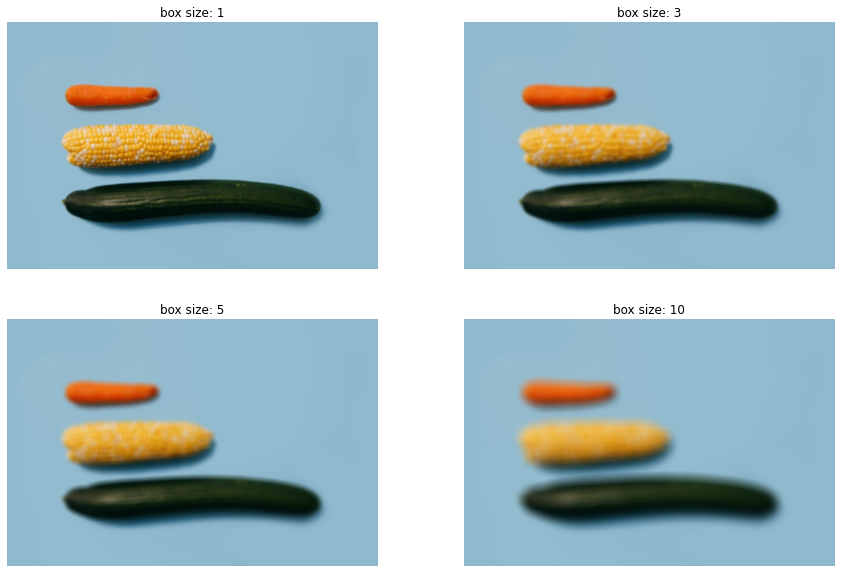

In [60]:
 # Задаем размеры
plt.figure(figsize=(15, 10))
for i, box_size in enumerate([1, 3, 5, 10]):
    # Замылим изображение
    img_blured = np.array(img_pil.filter(ImageFilter.BoxBlur(box_size)))
    # Отобразим изображение
    plt.subplot(2, 2, i+1)
    plot_image(img_blured, f'box size: {box_size}')

Гауссово сглаживание

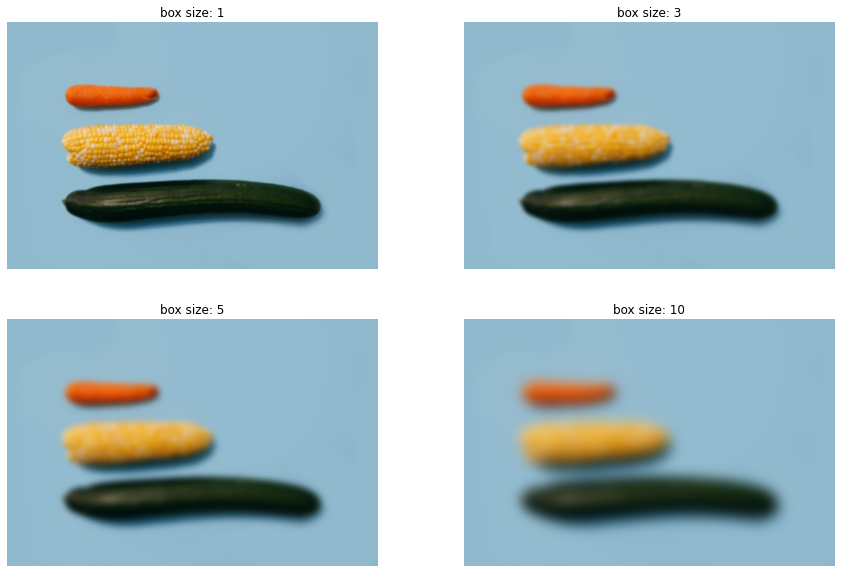

In [61]:
 # Задаем размеры
plt.figure(figsize=(15, 10))
for i, box_size in enumerate([1, 3, 5, 10]):
    # Замылим изображение
    img_blured = np.array(img_pil.filter(ImageFilter.GaussianBlur(box_size)))
    # Отобразим изображение
    plt.subplot(2, 2, i + 1)
    plot_image(img_blured, f'box size: {box_size}')

Применим GM для изображения с mean filter и размером окна=3

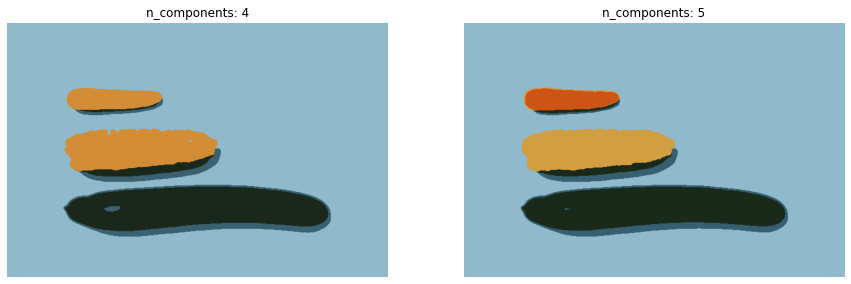

In [183]:
# Получили замыленное изображение
img_blured = np.array(img_pil.filter(ImageFilter.BoxBlur(3)))
# Задали размер графика
plt.figure(figsize=(15, 7))
for i, n_components in enumerate([4, 5]):
    # Подготовили модель
    model = GM(n_components=n_components, covariance_type='tied')
    # Получили сегментацию при помощи моей ф-ции
    image_segmented = perform_segmentation(img_blured, img_flat_simple, model)
    # Отобразили
    plt.subplot(1, 2, i+1)
    plot_image(image_segmented, f'n_components: {n_components}')

Видно, что при 5-и компонентах и размытии сегментация довольно точна, но име.тся слежующий проблемы
* Часть кабачка принята за тень
* Часть кукурузы принята за кабачок

Применим MeanShift

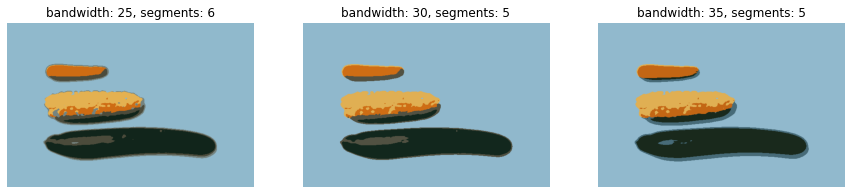

In [202]:
# Задали размер графика
plt.figure(figsize=(15, 6))
for i, bandwidth in enumerate([25, 30, 35]):
    # Подготовили модель
    model = MeanShift(bandwidth=bandwidth, max_iter=500, bin_seeding=True)
    img_mean_shift = perform_segmentation(img_blured, img_flat_simple, model)
    # Получили сегментацию при помощи моей ф-ции
    segments =np.unique(img_mean_shift.reshape(-1, 3),axis=0).shape[0]
    # Отобразили
    plt.subplot(1, 3, i+1)
    plot_image(img_mean_shift, f'bandwidth: {bandwidth}, segments: {segments}')

### Используем цветовое пространство L\*A\*B\*

In [77]:
img_lab = rgb2lab(img)

/home/vsevolod/miniconda3/envs/main/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


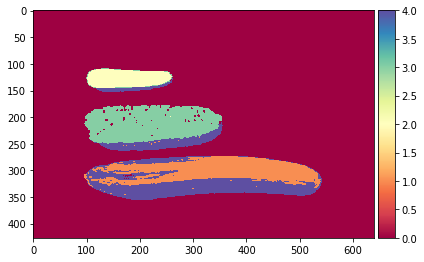

In [90]:
model = GM(n_components=5, covariance_type='tied')
X = img_flat_simple(img_lab)
segments = model.fit_predict(X)
img_segmented = segments.reshape(img.shape[:2])
imshow(img_segmented, cmap='Spectral')

/home/vsevolod/miniconda3/envs/main/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


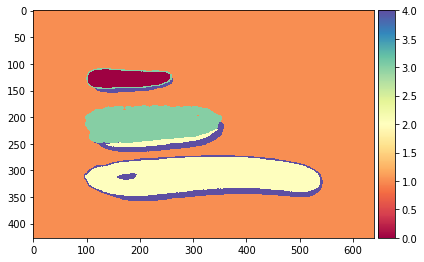

In [91]:
img_blured = np.array(img_pil.filter(ImageFilter.BoxBlur(3)))
img_blured_lab = rgb2lab(img_blured)
X = img_flat_simple(img_blured_lab)
segments = model.fit_predict(X)
img_segmented = segments.reshape(img.shape[:2])
imshow(img_segmented, cmap='Spectral')

Вывод: в цветовом пространстве LAB все те же проблемы, поэтому остановимся на  RGB

### Добавим координаты

In [184]:
def img_flat_with_coords(img):
    X = np.copy(img)
    x_coord = np.ones((427, 640)) * np.arange(640) / 639 * 255
    x_coord = x_coord[:, : , np.newaxis]
    y_coord = np.ones((427, 640)) * np.arange(427)[:, np.newaxis] / 426 * 255
    y_coord = y_coord[:, : , np.newaxis]
    X = np.concatenate([X, x_coord, y_coord], axis=2)
    return X.reshape(-1, 5)

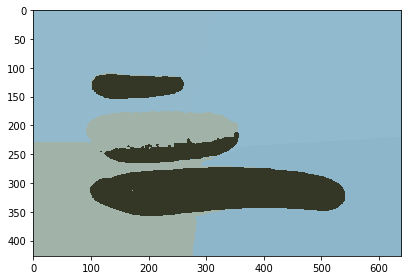

In [185]:
img_blured = np.array(img_pil.filter(ImageFilter.BoxBlur(3)))
model = GM(n_components=5, covariance_type='tied')
img_gm = perform_segmentation(img_blured, img_flat_with_coords, model)
imshow(img_gm)

Вывод: данный подход не дает существенного улучшения

### Найдем грани

In [186]:
img_blured_gray = rgb2gray(img_blured)

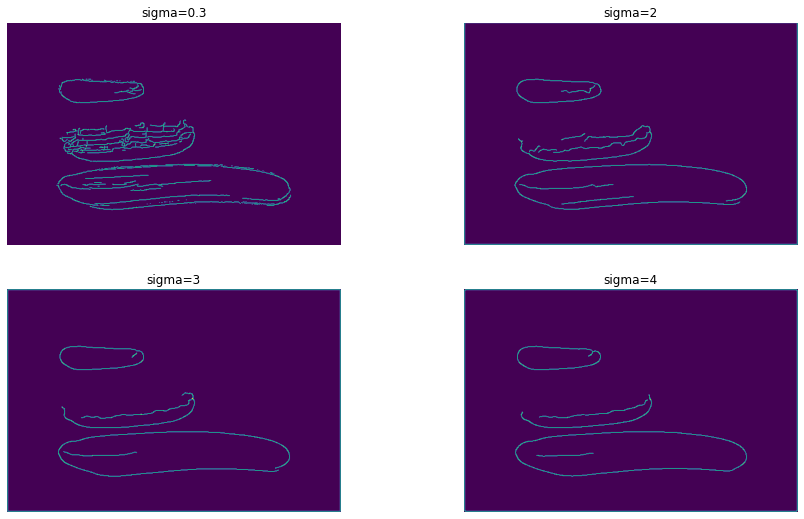

In [188]:
plt.figure(figsize=(15, 9))
for i, sigma in enumerate([0.3, 2, 3, 4]):
    edges = canny(img_blured_gray, sigma=sigma)
    plt.subplot(2, 2, i+1)
    plot_image(edges, f'sigma={sigma}')

Видно, что не получается удачно применить canny edge detection algorithm, поэтому он не позволит улучшить сегментацию

### otsu

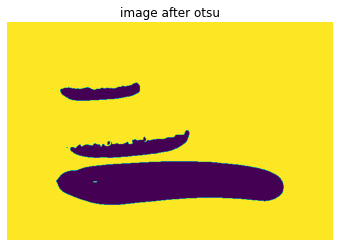

In [189]:
threshold = threshold_otsu(img_blured_gray)
img_binary = img_blured_gray > threshold
plot_image(img_binary, 'image after otsu')

Я надеелся, что otsu позволить отделить фон, чтобы облегчить дальнейшую сегментацию при помощи GMM и MeanShift, но ожидаемого результата не получил

### Применим felzenszwalb method основанный на графах для предобработки изображения

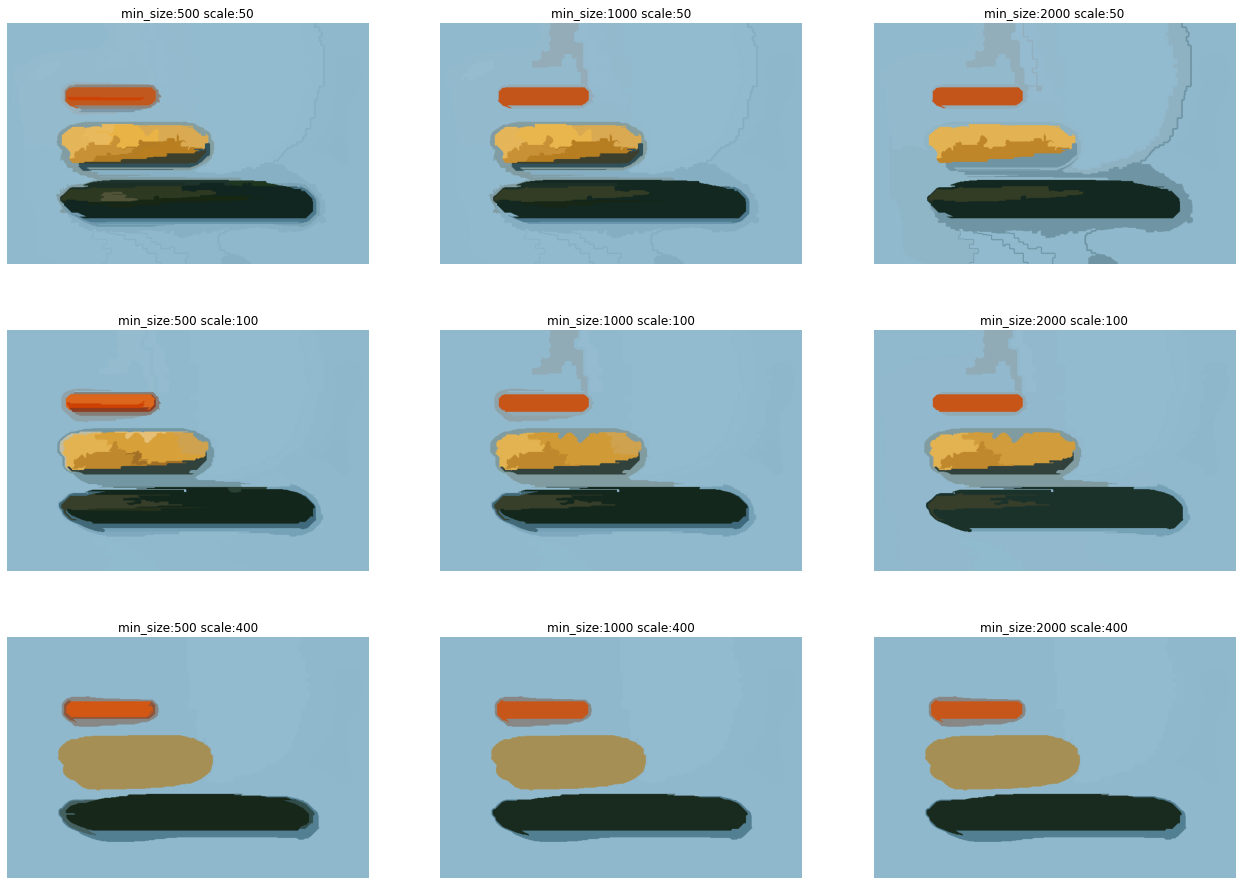

In [192]:
plt.figure(figsize=(22, 16))
i = 1
for scale in [50, 100, 400]:
    for min_size in [500, 1000, 2000]:
        segments_fz = felzenszwalb(img_blured, scale=scale, sigma=1, min_size=min_size)
        segments_fz = np.ravel(segments_fz)
        img_segmented = get_colors_from_clusters(img_blured, segments_fz)
        plt.subplot(3, 3, i)
        plot_image(img_segmented, f'min_size:{min_size} scale:{scale}')
        i += 1

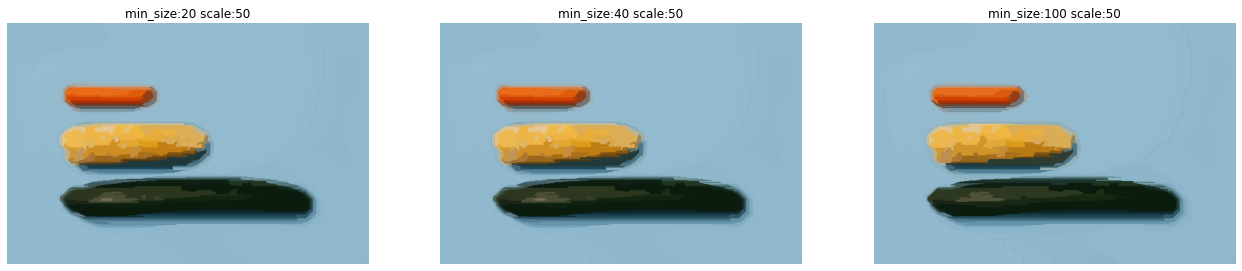

In [176]:
plt.figure(figsize=(22, 15))
i = 1
scale=50
for min_size in [20, 40, 100]:
    segments_fz = felzenszwalb(img_blured, scale=scale, sigma=1, min_size=min_size)
    segments_fz = np.ravel(segments_fz)
    img_segmented = get_colors_from_clusters(img_blured, segments_fz)
    plt.subplot(1, 3, i)
    plot_image(img_segmented, f'min_size:{min_size} scale:{scale}')
    i += 1

Применим GM для min_size:100 и scale:50

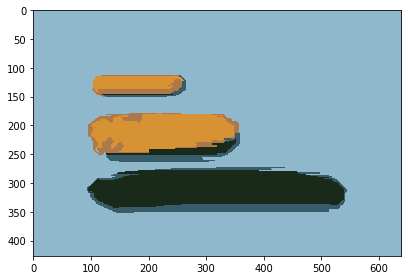

In [181]:
segments_fz = felzenszwalb(img_blured, scale=50, sigma=1, min_size=100)
segments_fz = np.ravel(segments_fz)
img_segmented = get_colors_from_clusters(img_blured, segments_fz)
img_segmented = perform_segmentation(img_segmented, img_flat_simple,model)
imshow(img_segmented)

Вывод: предсегментация не дает полезного результата и проявляет себя хуже чем простая сегментация на размытом изображении

## Вывод

Лучшая сегментация которую удалось добиться

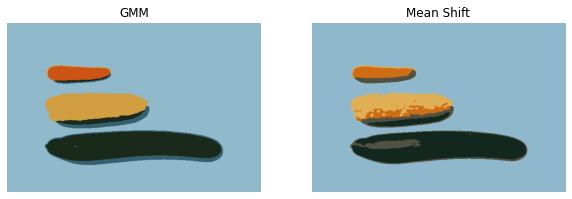

In [204]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
model = GM(n_components=5, covariance_type='tied')
image_segmented = perform_segmentation(img_blured, img_flat_simple, model)
plot_image(image_segmented, f'GMM')
plt.subplot(1, 2, 2)
model = MeanShift(bandwidth=30, max_iter=500, bin_seeding=True)
image_segmented = perform_segmentation(img_blured, img_flat_simple, model)
plot_image(image_segmented, f'Mean Shift')

В данном задании удалось реализовать  сегментацию изображения при помощи GMM и MeanShift. Оба алгоритма успешно справились с заданием

# Задание 3

In [10]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import Isomap, TSNE
from sklearn.decomposition import PCA

In [8]:
def compare_dim_reduction(X, y):
    """
    Ф-ция для отображение различных методов уменьшения размерности
    """
    model_and_name = [(TSNE(), 't-SNE'), (Isomap(), 'ISOMAP'), (PCA(), 'PCA')]
    plt.figure(figsize=(15, 8))
    i = 1
    for model, name in model_and_name:
        X_trans = model.fit_transform(X)
        plt.subplot(2, 2, i)
        plt.scatter(X_trans[:, 0], X_trans[:, 1], c=y, cmap='Spectral', s=50, alpha=0.5)
        plt.title(name)
        plt.colorbar()
        i += 1

In [6]:
def plot_images(rows, cols, img_X, img_shape, cmap='gray'):
    """
    Ф-ция для вывода изображений
    """
    i = 1
    # Подготавливаем размер и расположение подграфиков
    fig = plt.figure(figsize=(rows, cols))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05,
                        wspace=0.05)
    # Выбираем случайные изображения и отображаем их
    for img_row in np.random.choice(range(img_X.shape[0]), rows * cols):
        img = img_X[img_row].reshape(img_shape)
        # Отображаем
        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap=cmap)
        plt.axis('off')
        i += 1

### Isomap и t-SNE на синтетическом датасете swiss roll

In [11]:
n_samples = 1000
roll_coord, roll_color = make_swiss_roll(n_samples)

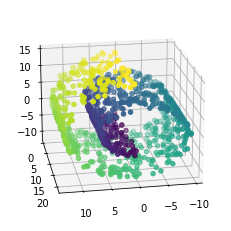

In [12]:
ax = plt.axes(projection='3d')
ax.scatter3D(roll_coord[:, 0], roll_coord[:, 1], roll_coord[:, 2], c=roll_color)
ax.view_init(20, 80)

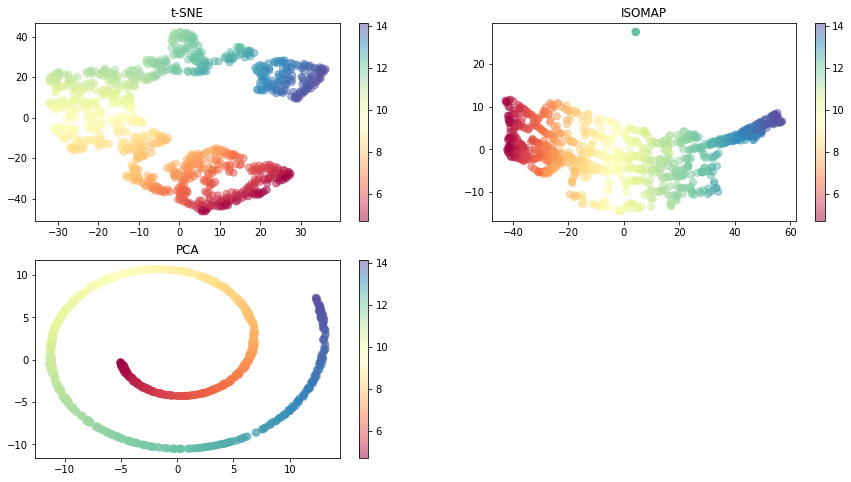

In [32]:
compare_dim_reduction(roll_coord, roll_color)

Вывод:
* ISOMAP отлично справился с задачей(при помощи него можно даже сделать 1-мерную проекцию данных)
* t-SNE справился хуэе, но все равно нашел структура у данных
* PCA успешно спроецировал в 2 измерения, а вот с 1-м будут проблемы

### ISOMAP и t-SNE для  mnist

Импортируем данные MNIST

In [27]:
from sklearn.datasets import load_digits

In [28]:
digits_dict = load_digits()
digits_X = digits_dict['data']
digits_y = digits_dict['target']

Отобразим данные

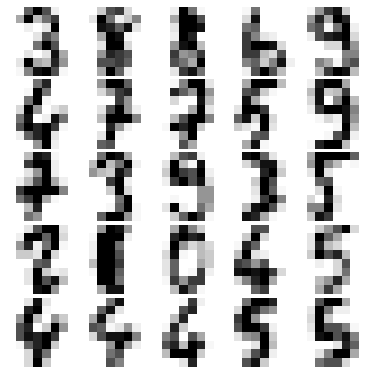

In [35]:
plot_images(5, 5, digits_X, (8, 8))

Сравним уменьшение размерности

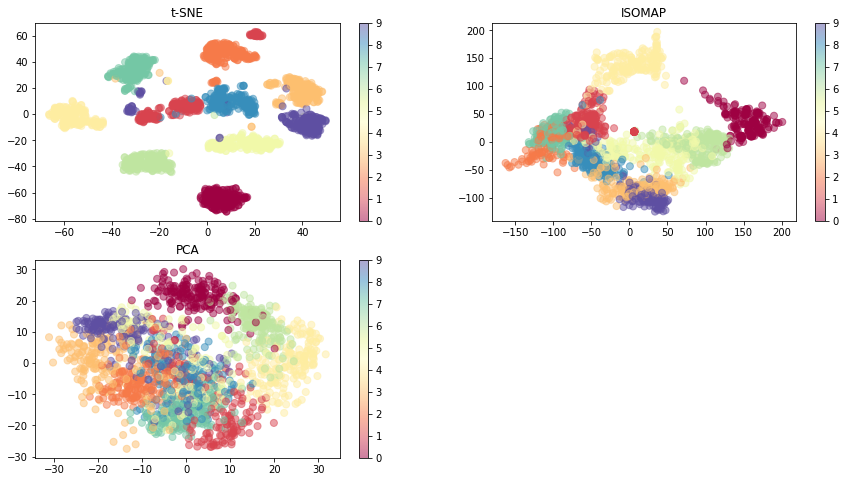

In [36]:
compare_dim_reduction(digits_X, digits_y)

Вывод:
* t-SNE практически идеально справился с задачей
* ISOMAP неплохо разделил данные, но имеются пересечения
* У PCA слишком много пересечений

## Лирическое отступление

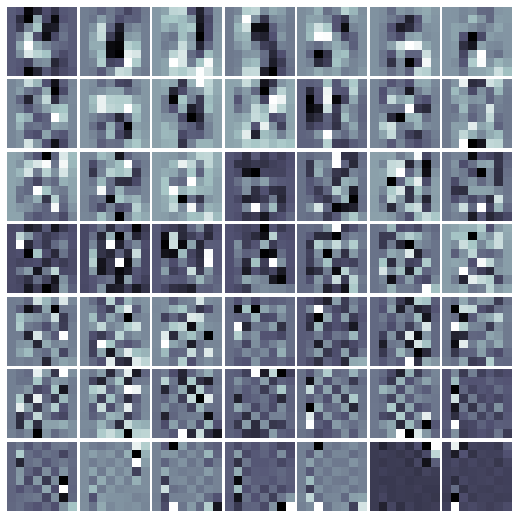

In [254]:
n_components = 49
pca = PCA(n_components=n_components)
X_olive_pca = pca.fit_transform(digits_X)
# Подготовим график и перменныне
i = 1
rows = int(np.sqrt(n_components))
cols = int(np.sqrt(n_components))
fig = plt.figure(figsize=(rows, cols))
fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.05, hspace=0.05)
for component in pca.components_:
    # Отобразим компоненты
    plt.subplot(rows, cols, i)
    plt.imshow(component.reshape(8, 8), cmap=plt.cm.bone)
    plt.axis('off')
    i += 1

# Задание 4

## Импортируем и покажем лица

Импортируем

In [58]:
from sklearn.datasets import fetch_olivetti_faces

In [59]:
def reshape_olive(X):
    return  X.reshape(64, 64)

Импортируем лица

In [60]:
olivetti_dict = fetch_olivetti_faces()
X_olive = olivetti_dict['data']
y_olive = olivetti_dict['target']

Отобразим лица при помощи моей ф-ции

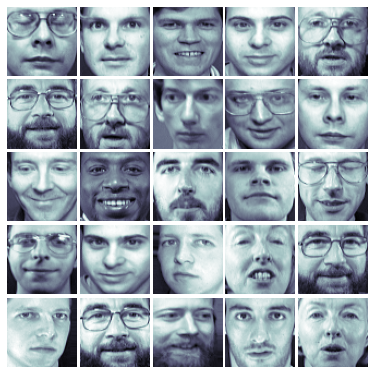

In [61]:
plot_images(5, 5, X_olive, (64, 64), cmap=plt.cm.bone)

## применим PCA и получим eigenfaces

Подготовим и уменьшим размерность при помощи PCA

In [62]:
n_components = 100
pca = PCA(n_components=n_components)
X_olive_pca = pca.fit_transform(X_olive)

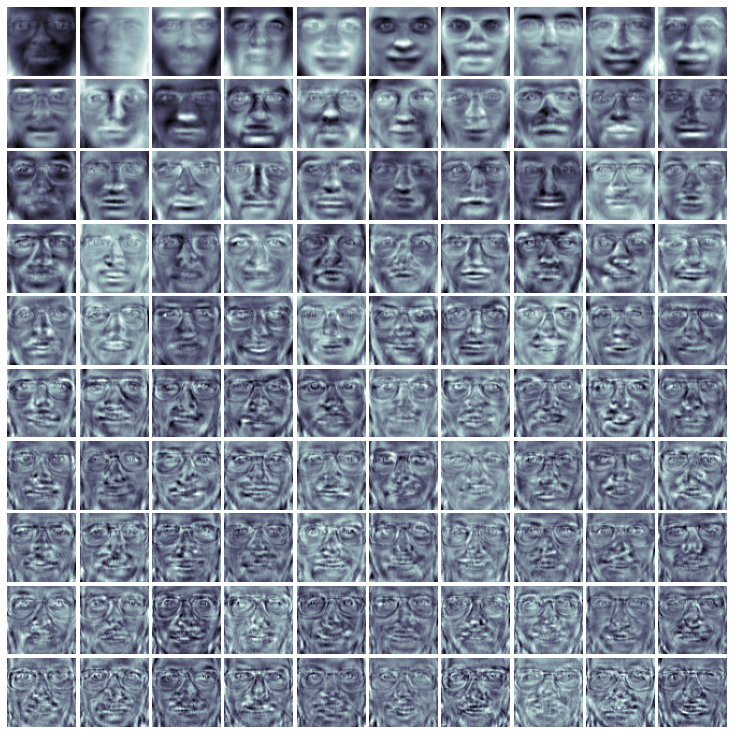

In [63]:
# Подготовим график и перменныне
i = 1
rows = int(np.sqrt(n_components))
cols = int(np.sqrt(n_components))
fig = plt.figure(figsize=(rows, cols))
fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.05, hspace=0.05)
for component in pca.components_:
    # Отобразим компоненты
    plt.subplot(rows, cols, i)
    plt.imshow(reshape_olive(component), cmap=plt.cm.bone)
    plt.axis('off')
    i+= 1

Покажем,что взвешенная сумма Eigenfaces способна отобразить лицо

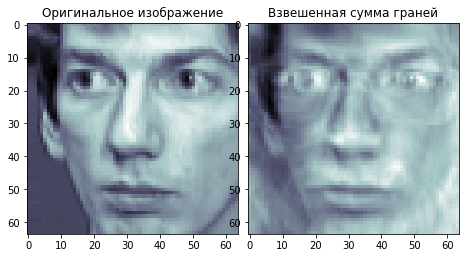

In [64]:
# Выберме случайное лицо
faces_cnt = X_olive.shape[0]
face_ind = np.random.randint(0, faces_cnt-1)
face = X_olive[face_ind]
# Получем коэффициенты лица
face_coefs = X_olive_pca[face_ind]
# Получим лицо как взвешенную сумму граней
face_from_coefs = np.sum(face_coefs[:, np.newaxis] * pca.components_, axis=0)

# Отобразим исходное лицо и лицо как взвешенную сумму
fig = plt.figure(figsize=(6, 3))
fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.05, hspace=0.05)
plt.subplot(1, 2, 1)
plt.imshow(reshape_olive(face), cmap=plt.cm.bone)
plt.title('Оригинальное изображение')
plt.subplot(1, 2, 2)
plt.imshow(reshape_olive(face_from_coefs), cmap=plt.cm.bone)
plt.title('Взвешенная сумма граней');

## Вывод

В данном задании нам удалось восстановить лицо при помощи взвешенной суммы  eigenfaces

# Задание 5

In [14]:
def compare_images(img, pca):
    """
    Ф-ция, которая отображает наиболее похожее изображение из тренировочных данных
    """
    # Получим изображение
    frame = img
    frame_X = frame.reshape(1, -1)
    # Трансформируем при помощи PCA
    frame_X_trans = pca.transform(frame_X)
    # Найдем расстояния
    distances = np.linalg.norm(frame_X_trans - X_lfw_trans, axis=1)
    # Найдем ближайшее изображение из тренировочных и мин. расстояние
    argmin = np.argmin(distances)
    e_r = distances[argmin]
    best_match = X_lfw[argmin]
    # Отобразим
    plt.subplot(1, 2, 1)
    plt.imshow(frame.reshape(64, 64), cmap='gray')
    plt.title('Исх. изоб.')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(best_match.reshape(64, 64), cmap='gray')
    plt.title('Наиб. похожее')
    plt.axis('off')
    print('Расстояние до ближайшего изображения:', e_r)


In [15]:
from skimage import img_as_float
from sklearn.model_selection import train_test_split

## Подготовим PCA

Импортируем изображения

In [24]:
from pathlib import Path
# Получим пути всех изображений
image_dir_path = 'lfw1000'
paths = [path.parts[-3:] for path in
         Path(image_dir_path).rglob('*.pgm')]
# Для каждого пути получим изображение
X_lfw = []
for path in paths:
    path = path[0] + '/' + path[1]
    img = img_as_float(imread(path, as_gray=True))
    img = np.ravel(img)
    X_lfw.append(img)
X_lfw = np.array(X_lfw)

Отобразим изображения

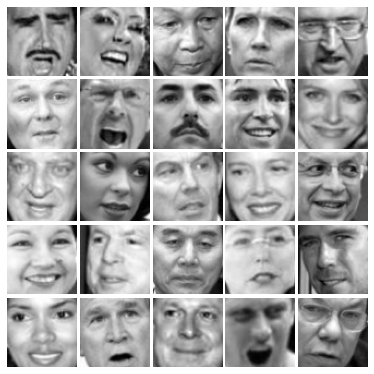

In [17]:
plot_images(5, 5, X_lfw, (64, 64))

Подготовим PCA

In [18]:
pca = PCA(n_components=50)
X_lfw_trans = pca.fit_transform(X_lfw)

### Попробуем добавить искажения на лица и посмотреть распознает ли их наш алгоритм

Расстояние до ближайшего изображения: 7.330488830709722


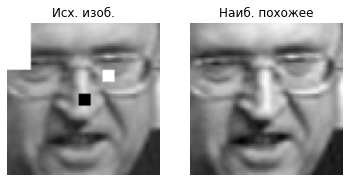

In [20]:
# Получим изображение
pic = np.copy(X_lfw[14]).reshape(64, 64)
# Добавим искажение
pic[30:35, 30:35] = 0
pic[20:25, 40:45] = 1
pic[0:20, 0:10] = 1
# Получим наиболее похожее изображение
compare_images(pic, pca);

Расстояние до ближайшего изображения: 5.136790220104792


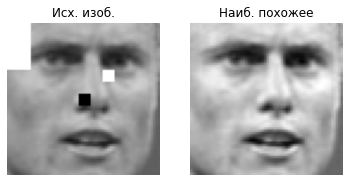

In [21]:
# Получим изображение
pic = np.copy(X_lfw[34]).reshape(64, 64)
# Добавим искажение
pic[30:35, 30:35] = 0
pic[20:25, 40:45] = 1
pic[0:20, 0:10] = 1
# Получим наиболее похожее изображение
compare_images(pic, pca);

Расстояние до ближайшего изображения: 9.180716700094552


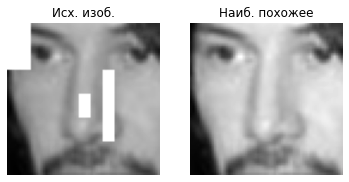

In [25]:
# Получим изображение
pic = np.copy(X_lfw[70]).reshape(64, 64)
# Добавим искажение
pic[30:40, 30:35] = 1
pic[20:50, 40:45] = 1
pic[0:20, 0:10] = 1
# Получим наиболее похожее изображение
compare_images(pic, pca);

Видно, что алгоритм успешно распознает лица

# Задание 6

Данные mnist уже импортированы, поэтому заново их импортировать не будем.
Cразу натренируем PCA и посмотрим какой процент распределения сохраняется в зависимости от количества компонент

## Определим количество компонент

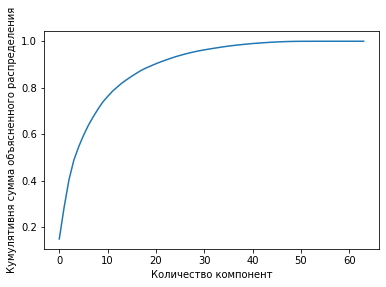

In [29]:
# Подготовим PCA
pca = PCA()
pca.fit(digits_X)
# Отобразим кол-во информации от количества компонент
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Количество компонент')
plt.ylabel('Кумулятивня сумма объясненного распределения');

Видно, что после 10 компонент начинается сильный спад, поэтому мы остановимся на 10

## Восстановим изображения

In [30]:
pca = PCA(n_components=10)
pca.fit(digits_X)

PCA(n_components=10)

Теперь проверим, что несмотря на то, что мы уменьшили пространство векторов до 20, мы сможим восстановить изображение с небольшой ошибкой

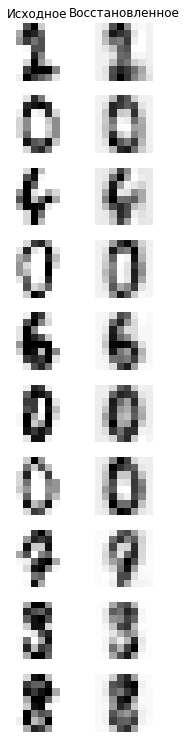

In [31]:

# Подготавливаем размер и расположение подграфиков
fig, axis = plt.subplots(10, 2, figsize=(2, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05,
                    wspace=0.5)
# Выбираем случайные изображения и отображаем их
axis[0, 0].set_title('Исходное')
axis[0, 1].set_title('Восстановленное')
for i, img_row in enumerate(np.random.choice(range(digits_X.shape[0]), 10)):
    # Получим цифру
    X = digits_X[img_row, np.newaxis]
    # Преобразуем и восстановим цифру
    X_trans = pca.transform(X)
    X_restored = pca.inverse_transform(X_trans)
    # Получим изображения
    img = X.reshape((8, 8))
    img_restored = X_restored.reshape((8, 8))
    # Отобразим изображения
    axis[i, 0].imshow(img, cmap='Greys')
    axis[i, 0].axis('off')
    axis[i, 1].imshow(img_restored, cmap='Greys')
    axis[i, 1].axis('off')

## Вывод

Несмотря на то, что мы уменьшили пространство векторов больше чем в 6 раз, изображения остались достаточно качественными

# Задание 7

In [52]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import train_test_split

Разделим на тестовые и тренировочные

In [50]:
X_train, X_test, y_train, y_test = train_test_split(digits_X, digits_y, train_size=0.8)

Получим точность

In [53]:
# Список параметров(количество соседей), который мы будем перебирать в цикле
neighbour_list = [3, 5, 9, 12, 15, 20, 25, 30]
# Списки для хрениния точности на тестовых и тренировочных данных
test_scores = []
train_scores = []
for n_neighbours in neighbour_list:
    # Инициализируем и обучим модель
    model = KNN(n_neighbors=n_neighbours)
    model.fit(X_train, y_train)
    # Получим и запишем точность
    test_score = model.score(X_test, y_test)
    test_scores.append(test_score)
    train_score = model.score(X_train, y_train)
    train_scores.append(train_score)

Отобразим точность

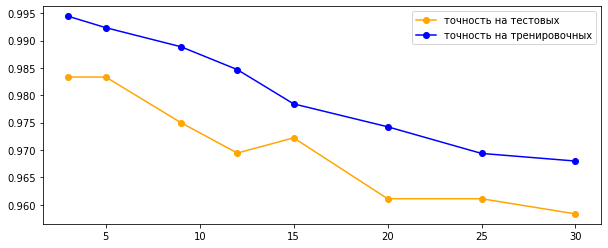

In [54]:
fig = plt.figure(figsize=(10, 4))
plt.plot(neighbour_list, test_scores, c='orange', marker='o', label='точность на тестовых')
plt.plot(neighbour_list, train_scores, c='blue', marker='o', label='точность на тренировочных')
plt.legend()

## Вывод

Видим, что наилучший результ достигается при мальньких значениях. При больших же значениях точность падает как на тренировочных(учебных) данных, так и на тестовых

# Задание 8

In [33]:
from scipy.stats import multivariate_normal
from tqdm import tqdm

In [34]:
def fit_generative_model(x, y, c_arr):
    """
    :param x:
    :param y:
    :param c_arr: Параметер регуляризации
    :return: Возвращает
    mu - Это матрица с центрами гауссового распределения
    sigma - Это 3-х мерная матрица с ковариационными матрицами для гауссова распределения
    pi - Это априорные вероятности
    """
    # Инициализируем mu, sigma, pi нулевыми матрицамми
    k = np.unique(y).size
    d = (x.shape)[1]
    mu = np.zeros((k,d))
    sigma = np.zeros((k,d,d))
    pi = np.zeros(k)
    # Для каждого класса
    for label in range(k):
        # Получим индексы этого класса
        indices = (y == label)
        # Посчитаем значения pi, mu, sigma для класса
        pi[label] = sum(indices) / float(len(y))
        mu[label] = np.mean(x[indices,:], axis=0)
        sigma[label] = np.cov(x[indices,:], rowvar=False, bias=True)
         # Добавим регуляризационный параметер для матрицы ковариации
        sigma[label] += c_arr[label]*np.eye(d)
    return mu, sigma, pi

In [37]:
def predict(x, mu, sigma, pi):
    """
    :return: Возвращает класс, который имеет наибольшую вероятность
    """
    # Инициализруем переменную для хранения вероятностей
    n_samples = x.shape[0]
    n_labels = 10
    scores = np.zeros((n_samples, n_labels))
    # Для каждого класса посчитаем вероятность
    for label in range(0,n_labels):
        # Получим ф-цию гаусса
        rv = multivariate_normal(mean=mu[label], cov=sigma[label])
        # Для каждой записи в данных, на которых надо предсказать
        for i in range(n_samples):
            # Считаем вероятность
            scores[i,label] = np.log(pi[label]) + rv.logpdf(x[i,:])
    # Предсказанный класс = класс с наибольшей вероятностью
    test_predictions = np.argmax(scores, axis=1)
    return test_predictions

## Разделим на тренировочные и тестовые данные

In [47]:
X_train,X_test, y_train, y_test = train_test_split(digits_X, digits_y, train_size=0.7)

## Лирическое отступление

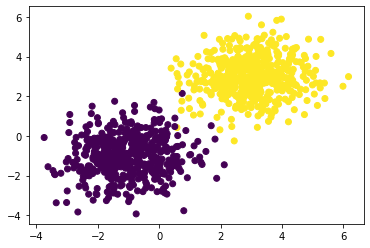

In [41]:
X_toy, y_toy= make_blobs(n_samples=1000, centers=[[-1, -1],[3, 3]])
plt.scatter(X_toy[:, 0], X_toy[:, 1], c=y_toy)

In [42]:
mu, sigma, pi = fit_generative_model(X_toy, y_toy, [1, 1])

Выведем центры гауссовых распредлеений

In [43]:
mu

array([[-1.01899471, -1.00137896],
       [ 2.99553811,  3.00339703]])

Выведем матрицы ковариаций гауссовых распределений

In [44]:
sigma

array([[[2.00391722, 0.08151078],
        [0.08151078, 2.0082198 ]],

       [[2.00062461, 0.09652566],
        [0.09652566, 1.98460792]]])

In [69]:
sigma[1]

array([[ 1.86094621, -0.06500893],
       [-0.06500893,  2.00342326]])

Априорные веротяности

In [49]:
pi

array([0.5, 0.5])

Получим ф-цию Гаусса для 1-го класса найдем ее значени примерно в центре

In [61]:
rv = multivariate_normal(mean=mu[0], cov=sigma[0])
rv.pdf([-1, -1])

0.07962462587305306

## Эксперенетируем с регуляризацией

In [45]:
def get_accuracy(c_arr):
    """
    Вспомогательная ф-ция для получения точнсти на MNIST при заданных значениях регуляризации
    """
    mu, sigma, pi = fit_generative_model(X_train, y_train, c_arr)
    y_predicted = predict(X_test, mu, sigma, pi)
    accuracy = round(np.mean(y_predicted == y_test), 3)
    return accuracy

### Что будет если регуляризация отсутствует

In [46]:
get_accuracy([0]*10)

LinAlgError: singular matrix

## Смотрим точность модели при различных значениях регуляризации

In [48]:
# Список значения регулярищации
c_list = [0.001, 1, 3, 10, 100, int(1e4), int(1e6)]
for c in c_list:
    # Выводим точнсть для каждого из значений
    accuracy = get_accuracy([c] * 10)
    print(f'Значение c: {c}, Точность: {accuracy}')

Значение c: 0.001, Точность: 0.948
Значение c: 1, Точность: 0.993
Значение c: 3, Точность: 0.994
Значение c: 10, Точность: 0.993
Значение c: 100, Точность: 0.976
Значение c: 10000, Точность: 0.463
Значение c: 1000000, Точность: 0.087


## Попробуем использовать различные параметры регуляризации для каждой из цифр

Суть алгоритма:
* Инициализирую список c
* Постепенно буду увеличивать каждый из c до тех пор пока ошибка не начнет увеличиваться

In [49]:
# Инициализурем перменные
start_c = 1
c_list = [start_c] * 10
mult = 2
# Инициализируем предыдущую лучшую точность, чтобы с ней сравнивать
prev_score = get_accuracy(c_list)
best_score = prev_score
for label in tqdm(range(10)):
    # Пока точность не упала
    while True:
        # Получить новую точность
        c_list[label] *= mult
        cur_score = get_accuracy(c_list)
        # Если точность лучше чем наибольшая, то обновить наибольшую
        if cur_score > best_score:
            best_score = cur_score
            best_c_list = c_list.copy()
        # Если точность упала, то выйти из цикла
        if cur_score < prev_score:
            c_list[label] /= mult
            break

print(
f"""
Лучшие значения регуляризации: {best_c_list}
Лучший результат модели: {best_score}
""")

100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


Лучшие значения регуляризации: [4.0, 1.0, 8.0, 4.0, 2, 1, 1, 1, 1, 1]
Лучший результат модели: 0.994



Вывод: в итоге нам удалось поднять точность модели до 0.989 при помощи использования различных параметров регуляризации для каждой из цифр

# Задание 9

In [50]:
from sklearn.datasets import fetch_lfw_people
from sklearn.ensemble import RandomForestClassifier
from dask import delayed
from skimage.transform import integral_image
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from  time import time

## Подготовим данные

In [51]:
# Импорируем данные
lfw_people = fetch_lfw_people(min_faces_per_person=200, resize=0.3)
# Иницализируем переменные, отвечающие за данные
y_lfw = lfw_people['target']
lfw_images  = lfw_people['images']
lfw_img_shape = lfw_images.shape[1:]
lfw_img_size = lfw_img_shape[0] * lfw_img_shape[1]
# Сделаем так чтобы у нас было только 100 записе, по 50 на каждого человека
one_label_cnt = 50

mask1 = y_lfw == 0
mask2 = y_lfw == 1
images1 = lfw_images[mask1][:one_label_cnt]
images2 = lfw_images[mask2][:one_label_cnt]
lfw_images = np.concatenate([images1, images2], axis=0)
y_lfw = np.array([0]*one_label_cnt + [1]*one_label_cnt)

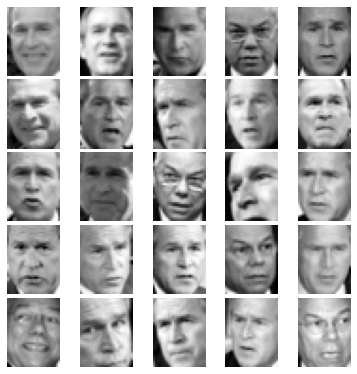

In [52]:
plot_images(5, 5, lfw_people['data'], lfw_img_shape)

## Получим haar-like признаки

In [53]:
@delayed
def extract_feature_image(img, feature_type, feature_coord=None):
    """
    Ф-ция для получения признаков Хаара
    """
    ii = integral_image(img)
    return haar_like_feature(ii, 0, 0, ii.shape[0], ii.shape[1],
                             feature_type=feature_type,
                             feature_coord=feature_coord)

In [54]:
# Получаем признаки Хаара
feature_types = ['type-2-x', 'type-2-y']
X = delayed(extract_feature_image(img, feature_types)
            for img in lfw_images)
# Засекаем время
X = np.array(X.compute(scheduler='processes'))
# Делим на тестовы и тренировочные данные
X_train, X_test, y_train, y_test = train_test_split(X, y_lfw,
                                                    train_size=0.8,
                                                    random_state=0,
                                                    stratify=y_lfw)

100%|██████████| 100/100 [00:00<00:00, 6236.79it/s]


## Тренируем модели

In [55]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
# Подготовим классификатор Случайных лесов принятия решений
clf = RandomForestClassifier(n_estimators=1000,
                             max_depth=10,
                             n_jobs=-1,
                             random_state=0)
# Засекем время и обучим
t_start = time()
clf.fit(X_train, y_train)
time_full_train = time() - t_start
# Получим качество предсказаний
auc_full_features = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print('Тренировка модели на всех признаках')
print(
    f"""
    Качество предсказания(auc): {auc_full_features}
    Время обучения: {time_full_train}
    """
)


Тренировка модели на всех признаках

    Качество предсказания(auc): 0.76
    Время обучения: 6.700212478637695
    


Отберем признаки

In [56]:
# Получим количетсво признаков
features_cnt = X.shape[1]
# Найдем 3 процента замых важных признаков
perc_3_features = int(features_cnt * 3 / 100)
top_features = np.argsort(clf.feature_importances_)[::-1]
top_3_features = top_features[:perc_3_features]
# Отберем это 3 процента
X_train_feature_selected = X_train[:, top_3_features]
X_test_feature_selected = X_test[:, top_3_features]

Натренируем данные на отобранных признаках

In [57]:
# Засекем время и обучим модель
t_start = time()
clf.fit(X_train_feature_selected, y_train)
time_full_train = time() - t_start
auc_full_features = roc_auc_score(y_test,
                                  clf.predict_proba(X_test_feature_selected)[:, 1])
print('Тренировка модели на 3% признаков')
print(
    f"""
    Качество предсказания(auc): {auc_full_features}
    Время обучения: {time_full_train}
    """
)


Тренировка модели на 3% признаков

    Качество предсказания(auc): 0.78
    Время обучения: 5.6966283321380615
    


## Вывод

Отобрав признаки при помощи RandomForest мы смогли не только сократить время работы алгоритма, но и улучшить его качество